# Imports

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Data download

In [4]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-06-15 13:10:00--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.8’

names.txt.8         100%[===================>] 222.80K  --.-KB/s    in 0.006s  

2025-06-15 13:10:01 (37.9 MB/s) - ‘names.txt.8’ saved [228145/228145]



In [5]:
words =  open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
itos = {i+1:s for i, s in enumerate(stoi)}
stoi['.'] = 0
itos[0] = '.'

In [7]:
itos, stoi

({1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 {'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0})

# Models

### Untrained Model

In [8]:
N_untrained = torch.full((27, 27), 1.0 / 27.0)

In [9]:
g = torch.Generator().manual_seed(0)

for _ in range(20):
  i = 0
  res = ''
  while(True):
    i = torch.multinomial(N_untrained[i], 1, replacement=True, generator=g).item()
    res += itos[i]
    if(i == 0):
      print(res)
      break

bhrnrekvrcfhyjrenlf.
lumyuovtqjyotnhgxuul.
udrltrsroghvx.
qttygzsdskyuilbcsqfhznsrsnsxtwuwovgmiqhvhbmbsvfyg.
sxanod.
szkdw.
yzljuqahljmgmzivsztfck.
nskmnr.
gmzymbcck.
lobwavbmwnvnujwmwamdejaynpgikaztmkdcxslunhxulzpqrjurfphmmfagmigvfngmkrpskkkyjpctebsyioqchegfu.
jutgsmvqupfifzhectynoypnvqdwnozag.
ftxyrgbumhav.
cbbafzmcmgvwnbwmbdfdycbszhxofkvukkizyyszxw.
hjciuaatbwyvmzjnykbeahdna.
ynldmiyrvyhgbugtwwjkbo.
.
gumfhdy.
vmskqblvcpufm.
byysuvydnnbrtcnigigviulsxdhobpmqmdcbjwweiiycuidkwfacjomricdwtbahmwxrfuqoeviqjdxtyoss.
qlfniozrasphplgkwcoqyzgtvlhrdguvopavoix.


### Statistical Model (Without NN)

In [10]:
train_size = int(0.8*len(words))
X_train = words[:train_size]
X_test = words[train_size:]

In [11]:
map = np.zeros((27,27), dtype=int)
for w in X_train:
  word = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(word, word[1:]):
    map[stoi[ch1], stoi[ch2]] += 1
    #print(ch1, ch2)

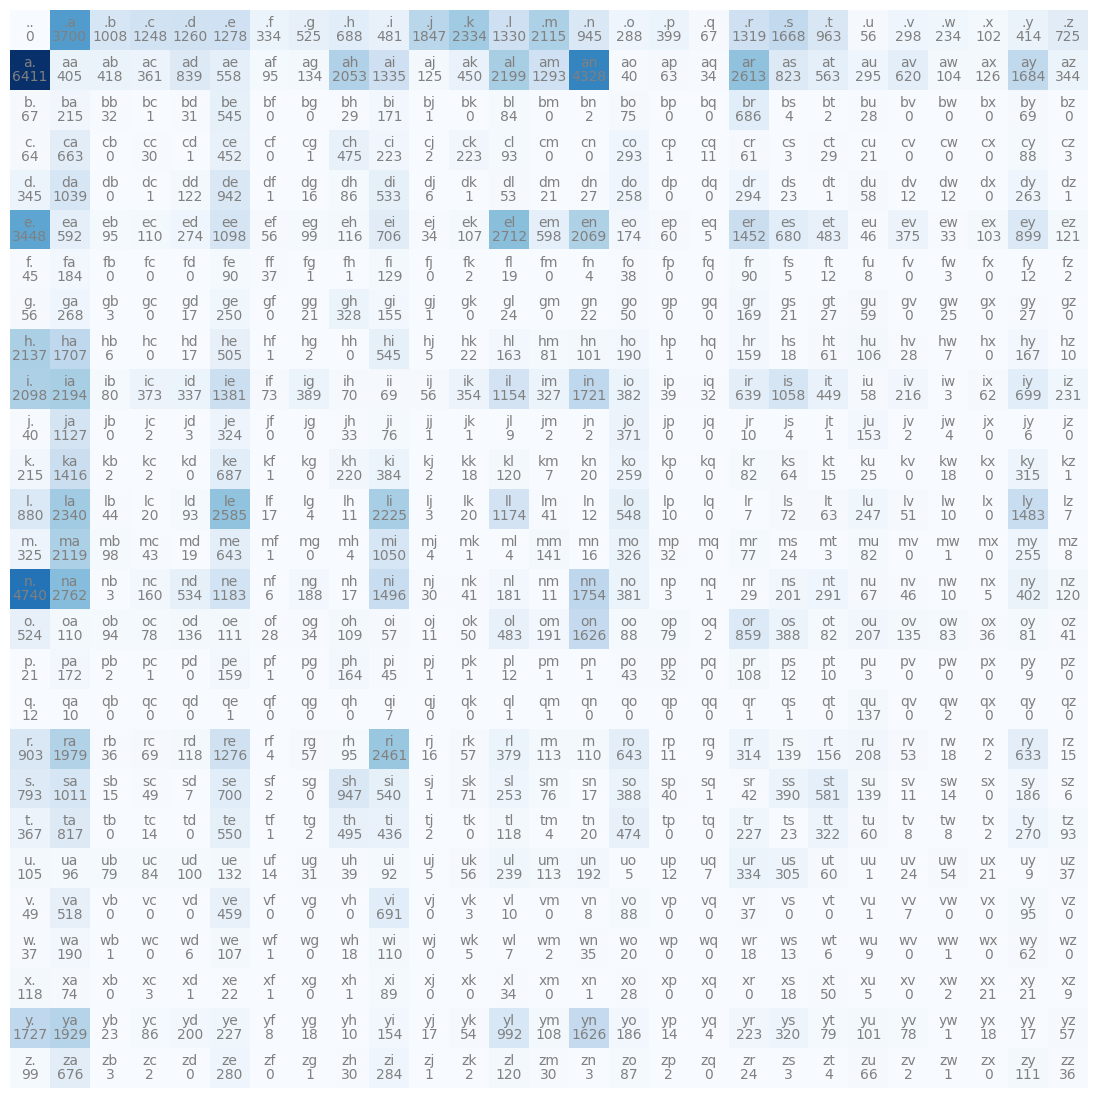

In [12]:
plt.figure(figsize=(14,14))
plt.imshow(map, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, map[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [13]:
N = torch.tensor(map).float() + 1.0
N /= N.sum(1, keepdim=True)

In [14]:
g = torch.Generator().manual_seed(0)

for _ in range(20):
  i = 0
  res = ''
  while(True):
    i = torch.multinomial(N[i], 1, replacement=True, generator=g).item()
    res += itos[i]
    if(i == 0):
      print(res)
      break

bhriretorco.
maren.
f.
lemauovieiynana.
sa.
l.
merlershonine.
stty.
zade.
drilyarlll.
n.
ssos.
touson.
ainavibe.
seshi.
shanou.
sa.
ja.
khalalahlimemonasstele.
n.


Loss calculation

In [15]:
n = 0
nll = 0
for w in X_test:
  word = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(word, word[1:]):
    i1 = stoi[ch1]
    i2 = stoi[ch2]
    prob = N[i1, i2]
    log_prob = prob.log()
    nll += abs(log_prob)
    n +=1

print((nll/n).item())

2.593641757965088


### One Neural Network


In [38]:
def build_dataset(words):
  xs, ys = [], []

  for w in words:
    word = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(word, word[1:]):
      i1 = stoi[ch1]
      i2 = stoi[ch2]
      xs.append(i1)
      ys.append(i2)

  X = torch.tensor(xs)
  Y = torch.tensor(ys)
  return X, Y
X_train, Y_train = build_dataset(words[:train_size])
X_test, Y_test = build_dataset(words[train_size:])

In [39]:
g = torch.Generator().manual_seed(0)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [40]:
for i in range(10000):
  # forward pass
  X_encoded = F.one_hot(X_train, num_classes=27).float()
  logits = X_encoded @ W
  # probs = F.softmax(logits, dim=1)

  # loss = -probs[torch.arange(len(X_train)), Y_train].log().mean()
  loss = F.cross_entropy(logits, Y_train)

  # backward pass
  W.grad = None
  loss.backward()

  # update
  W.data += -100 * W.grad
  if i % 1000 == 0:
    print(loss.item())

3.7727882862091064
2.478393077850342
2.4438257217407227
2.458197593688965
2.4638373851776123
2.429513454437256
2.4565417766571045
2.465829372406006
2.4569268226623535
2.4380435943603516


Loss calculation

In [41]:
X_encoded = F.one_hot(X_test, num_classes=27).float()
logits = X_encoded @ W
loss = F.cross_entropy(logits, Y_test)
loss.item()

2.610574245452881

In [42]:
g = torch.Generator().manual_seed(0)

for _ in range(20):
  i = 0
  res = ''
  while(True):
    X_encoded = F.one_hot(torch.tensor([i]), num_classes=27).float()
    logits = X_encoded @ W
    result = F.softmax(logits, dim=1)
    i = torch.multinomial(result, 1, replacement=True, generator=g).item()
    res += itos[i]
    if(i == 0):
      print(res)
      break

bhriretorco.
maren.
f.
lemauovieiynan.
jan.
l.
merlershonin.
aytty.
zade.
drilyarlll.
n.
ssos.
touson.
ainavibe.
seshi.
shanou.
sa.
ja.
khalalahlimemonasstele.
n.


### MLP

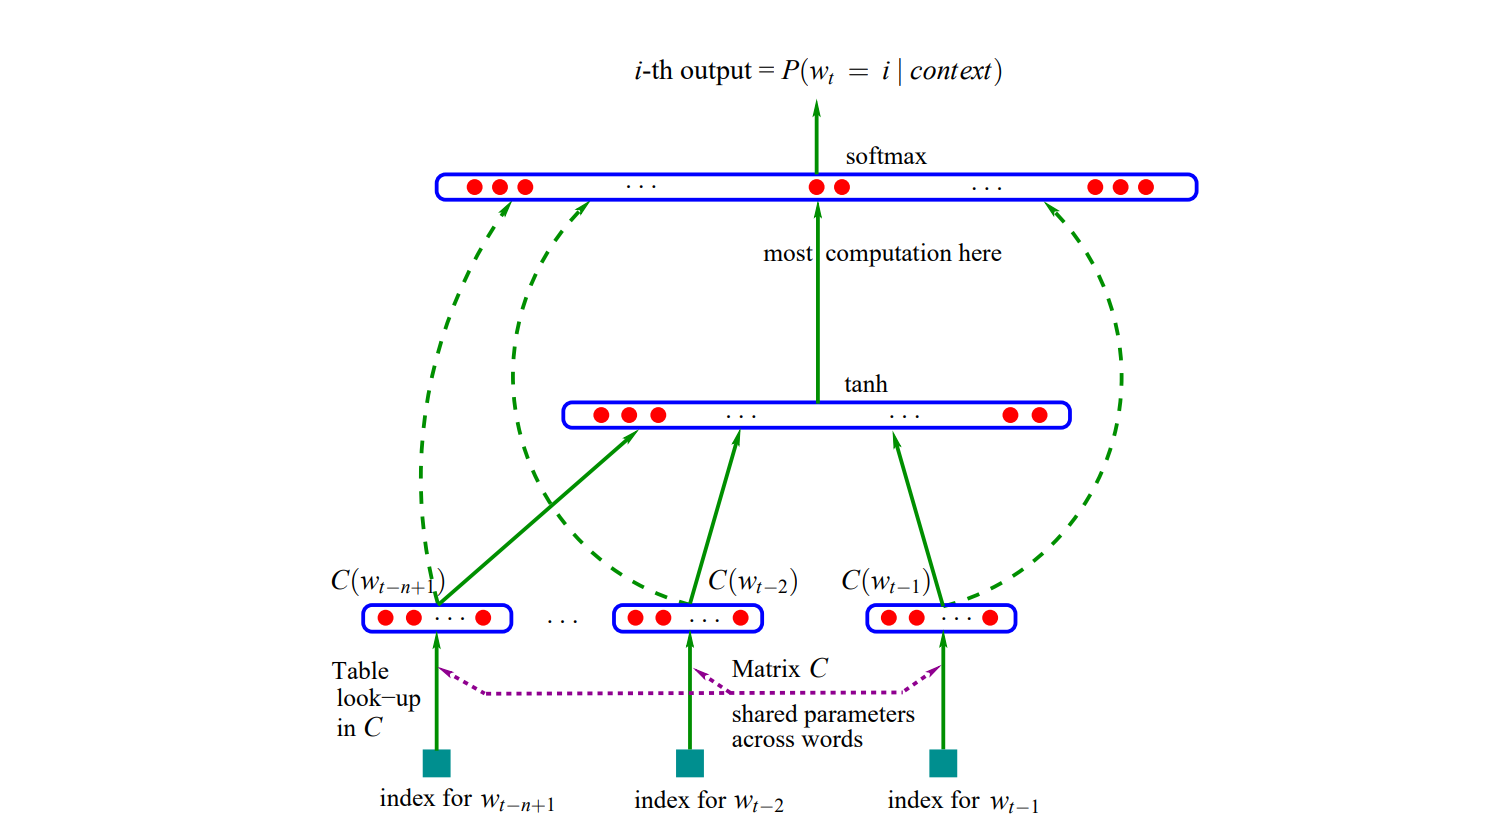

In [43]:
block_size = 3
vocab_size = 27
def build_dataset_MLP(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      index = stoi[ch]
      X.append(context)
      Y.append(index)
      context = context[1:] + [index]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

X_train_MLP, Y_train_MLP = build_dataset_MLP(words[:train_size])
X_test_MLP, Y_test_MLP = build_dataset_MLP(words[train_size:])

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([45368, 3]) torch.Size([45368])


In [44]:
g = torch.Generator().manual_seed(2147483647)
ndim = 10
hidden_units = 200

C = torch.randn((vocab_size, ndim), generator=g)
W1 = torch.randn((ndim * block_size, hidden_units), generator=g) * (5/3)/((ndim * block_size)**0.5) #* 0.2
# b1 = torch.randn(hidden_units, generator=g)
W2 = torch.randn((hidden_units, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, hidden_units))
bnbias = torch.zeros((1, hidden_units))
bnmean_running = torch.zeros((1, hidden_units))
bnstd_running = torch.ones((1, hidden_units))

parameters = [C, W1, W2, b2, bngain, bnbias]

In [45]:
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [46]:
for p in parameters:
  p.requires_grad = True

In [47]:
lossi = []

In [48]:
g = torch.Generator().manual_seed(2147483647)

batch_size = 32
for i in range(100000):

  ix = torch.randint(0, len(X_train_MLP), (batch_size,))

  # forward pass
  emb = C[X_train_MLP[ix]]
  # Linear layer
  hpreact = emb.view(-1, block_size * ndim) @ W1
  # BatchNorm layer
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # Non-linearity
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train_MLP[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(i, loss.item())
  lossi.append(loss.log10().item())

0 3.2948944568634033
10000 1.9906220436096191
20000 1.9437530040740967
30000 2.3800759315490723
40000 2.1025614738464355
50000 2.1592743396759033
60000 2.076587677001953
70000 2.2372360229492188
80000 2.4492266178131104
90000 2.2286901473999023


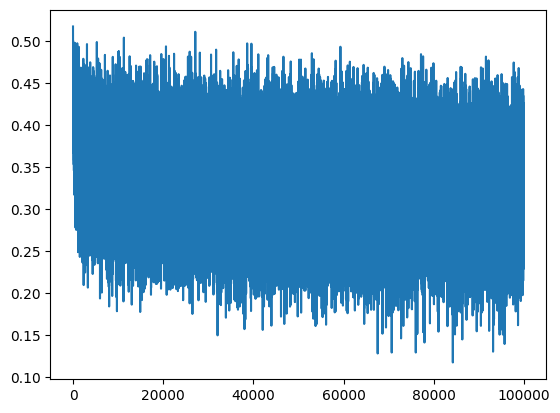

In [49]:
plt.plot(lossi)

Loss calculation

In [50]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train_MLP, Y_train_MLP),
    'test': (X_test_MLP, Y_test_MLP),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 2.094072103500366
test 2.400843381881714


![Screenshot 2025-06-12 202506.png](<attachment:Screenshot 2025-06-12 202506.png>)
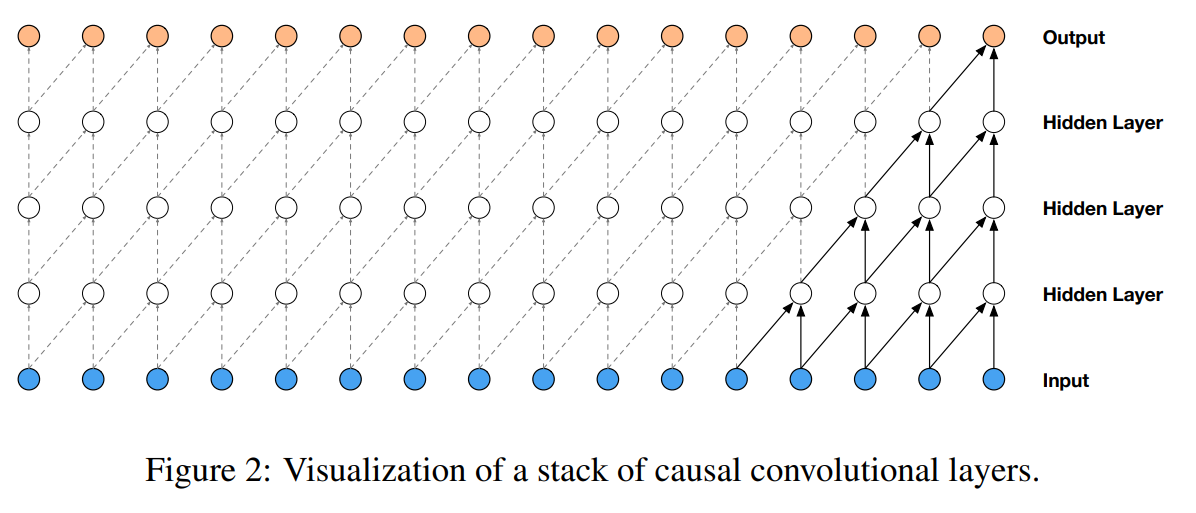

In [29]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, tensor):
    self.out = tensor @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, num_features, eps=1e-5, momentum=0.01):
    self.eps = eps
    self.num_features = num_features
    self.momentum = momentum
    self.training = True
    # parameters
    self.gamma = torch.ones((1, num_features))
    self.beta = torch.zeros((1, num_features))
    # buffers
    self.running_mean = torch.zeros((1, num_features))
    self.running_var = torch.ones((1, num_features))

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # update the buffers
    if self.training:
      self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
      self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out

  def parameters(self):
    return [self.gamma] + [self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    # 4, 8, 10
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [30]:
block_size = 8
vocab_size = 27
def build_dataset_MLP(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      index = stoi[ch]
      X.append(context)
      Y.append(index)
      context = context[1:] + [index]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

X_train_MLP, Y_train_MLP = build_dataset_MLP(words[:train_size])
X_test_MLP, Y_test_MLP = build_dataset_MLP(words[train_size:])

torch.Size([182778, 8]) torch.Size([182778])
torch.Size([45368, 8]) torch.Size([45368])


In [31]:
g = torch.Generator().manual_seed(2147483647)
ndim = 24
hidden_units = 128

C = torch.randn((vocab_size, ndim), generator=g)
model = Sequential([
  Embedding(vocab_size, ndim),
  FlattenConsecutive(2), Linear(ndim * 2, hidden_units, bias=False), BatchNorm1d(hidden_units), Tanh(),
  FlattenConsecutive(2), Linear(hidden_units*2, hidden_units, bias=False), BatchNorm1d(hidden_units), Tanh(),
  FlattenConsecutive(2), Linear(hidden_units*2, hidden_units, bias=False), BatchNorm1d(hidden_units), Tanh(),
  Linear(hidden_units, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [32]:
g = torch.Generator().manual_seed(2147483647)
max_steps = 200000
batch_size = 32
for i in range(max_steps):

  # mini-batch
  ix = torch.randint(0, X_train_MLP.shape[0], (batch_size,))

  # forward pass
  x = X_train_MLP[ix]
  logits = model(x)
  loss = F.cross_entropy(logits, Y_train_MLP[ix])


  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(i, loss.item())

  lossi.append(loss.log10().item())

0 3.290566921234131
10000 1.9617456197738647
20000 2.366020679473877
30000 1.9586366415023804
40000 1.7314395904541016
50000 2.169903516769409
60000 1.8159681558609009
70000 1.8919520378112793
80000 1.8902455568313599
90000 1.8760197162628174
100000 1.9641472101211548
110000 1.9668079614639282
120000 2.123368263244629
130000 1.9169014692306519
140000 1.8821460008621216
150000 2.0387465953826904
160000 1.5154865980148315
170000 1.937062382698059
180000 1.3734819889068604
190000 1.5578007698059082


In [33]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


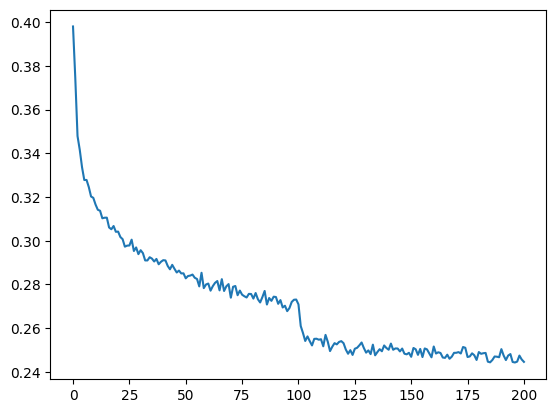

In [34]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [35]:
for layer in model.layers:
  layer.training = False

In [36]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train_MLP, Y_train_MLP),
    'test': (X_test_MLP, Y_test_MLP),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('test')

train 1.7431056499481201
test 2.2612621784210205


In [37]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

fredhika.
aariyome.
demoni.
nour.
deael.
natalia.
violen.
melam.
myulie.
sumayyah.
sophya.
hakari.
clizette.
lenney.
inalis.
estane.
betmani.
leeloia.
venna.
taylee.


# Results

#### Without Training

In [ ]:
g = torch.Generator().manual_seed(0)

for _ in range(20):
  i = 0
  res = ''
  while(True):
    i = torch.multinomial(N_untrained[i], 1, replacement=True, generator=g).item()
    res += itos[i]
    if(i == 0):
      print(res)
      break

bhrnrekvrcfhyjrenlf.
lumyuovtqjyotnhgxuul.
udrltrsroghvx.
qttygzsdskyuilbcsqfhznsrsnsxtwuwovgmiqhvhbmbsvfyg.
sxanod.
szkdw.
yzljuqahljmgmzivsztfck.
nskmnr.
gmzymbcck.
lobwavbmwnvnujwmwamdejaynpgikaztmkdcxslunhxulzpqrjurfphmmfagmigvfngmkrpskkkyjpctebsyioqchegfu.
jutgsmvqupfifzhectynoypnvqdwnozag.
ftxyrgbumhav.
cbbafzmcmgvwnbwmbdfdycbszhxofkvukkizyyszxw.
hjciuaatbwyvmzjnykbeahdna.
ynldmiyrvyhgbugtwwjkbo.
.
gumfhdy.
vmskqblvcpufm.
byysuvydnnbrtcnigigviulsxdhobpmqmdcbjwweiiycuidkwfacjomricdwtbahmwxrfuqoeviqjdxtyoss.
qlfniozrasphplgkwcoqyzgtvlhrdguvopavoix.


#### One Small Neural Network

In [ ]:
g = torch.Generator().manual_seed(0)

for _ in range(20):
  i = 0
  res = ''
  while(True):
    i = torch.multinomial(N[i], 1, replacement=True, generator=g).item()
    res += itos[i]
    if(i == 0):
      print(res)
      break

bhriretorco.
maren.
f.
lemauovieiynana.
sa.
l.
merlershonine.
stty.
zade.
drilyarlll.
n.
ssos.
touson.
ainavibe.
seshi.
shanou.
sa.
ja.
khalalahlimemonasstele.
n.


#### Deep Neural Netwrok
- Embedding : (32, 8, 24)
- FlattenConsecutive : (32, 4, 48)
- Linear : (32, 4, 128)
- BatchNorm1d : (32, 4, 128)
- Tanh : (32, 4, 128)
- FlattenConsecutive : (32, 2, 256)
- Linear : (32, 2, 128)
- BatchNorm1d : (32, 2, 128)
- Tanh : (32, 2, 128)
- FlattenConsecutive : (32, 256)
- Linear : (32, 128)
- BatchNorm1d : (32, 128)
- Tanh : (32, 128)
- Linear : (32, 27)

In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

fredhika.
aariyome.
demoni.
nour.
deael.
natalia.
violen.
melam.
myulie.
sumayyah.
sophya.
hakari.
clizette.
lenney.
inalis.
estane.
betmani.
leeloia.
venna.
taylee.
